In [13]:
import gzip
import scipy.io
import scipy.sparse
import numpy as np
from pybloom_live import BloomFilter
import random
import pickle  # To serialize Bloom filters
import time
import loompy
import matplotlib.pyplot as plt

In [20]:
# --- Helper: check if two vectors match (exact or approximate) ---
def vectors_match(v1, v2, tol=1e-8):
    return np.allclose(v1, v2, atol=tol, rtol=0)

# --- 1. MTX (.mtx → CSR or CSC) ---
def vector_exists_in_mtx(filename, v_g, tol=1e-8):
    matrix = scipy.io.mmread(filename).tocsr()
    for i in range(matrix.shape[0]):
        if vectors_match(matrix[i, :].toarray().flatten(), v_g, tol):
            return True
    return False

# --- 2. MTX.GZ ---
def vector_exists_in_mtx_gz(filename_gz, v_g, tol=1e-8):
    with gzip.open(filename_gz, "rt") as f:
        matrix = scipy.io.mmread(f).tocsr()
    for i in range(matrix.shape[0]):
        if vectors_match(matrix[i, :].toarray().flatten(), v_g, tol):
            return True
    return False

# --- 3. Loom format ---
def vector_exists_in_loom(filename, v_g, tol=1e-8):
    with loompy.connect(filename, 'r') as ds:
        for i in range(ds.shape[0]):
            if vectors_match(ds[i, :], v_g, tol):
                return True
    return False

# --- 3. CSR format ---
def vector_exists_in_csr_npz(npz_file, v_g, tol=1e-8):
    matrix = scipy.sparse.load_npz(npz_file)
    for i in range(matrix.shape[0]):
        if vectors_match(matrix[i, :].toarray().flatten(), v_g, tol):
            return True
    return False

# --- 4. Bloom filter (lossy, approximate check only) ---
def vector_exists_in_bloom(bloom_file, v_g):
    with open(bloom_file, "rb") as f:
        data = pickle.load(f)
    bloom = data["filter"]
    reference = data["reference"]

    delta = reference - v_g

    l2 = np.linalg.norm(delta, ord=2)
    linf = np.max(np.abs(delta))
    argmax = np.argmax(np.abs(delta))

    # Important: this only tells you "maybe there's a match"
    return f"{l2}:{linf}:{argmax}" in bloom 

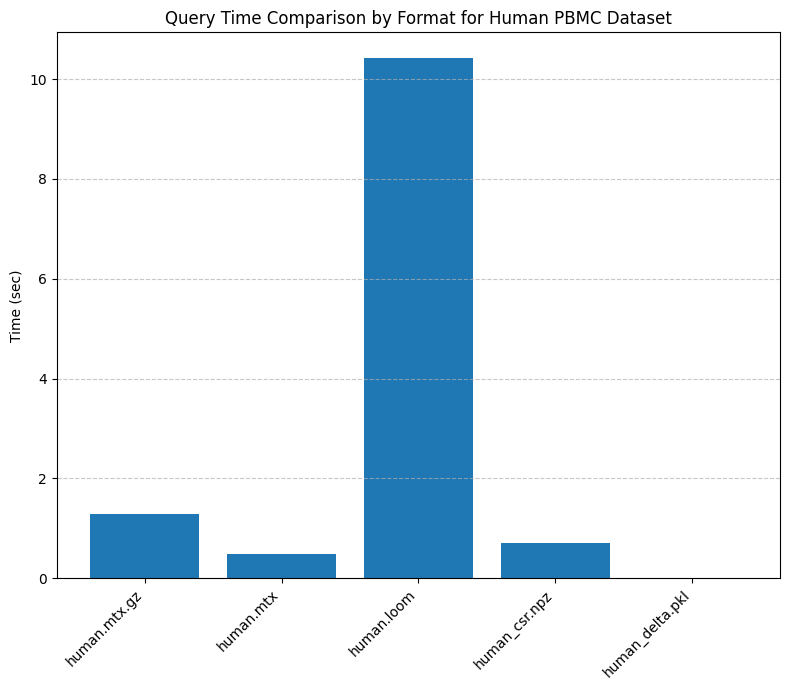

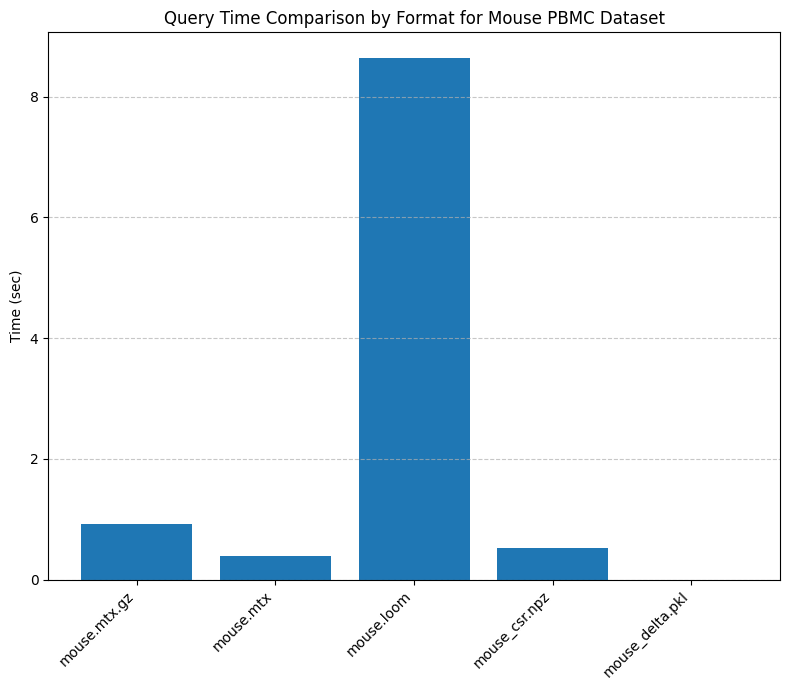

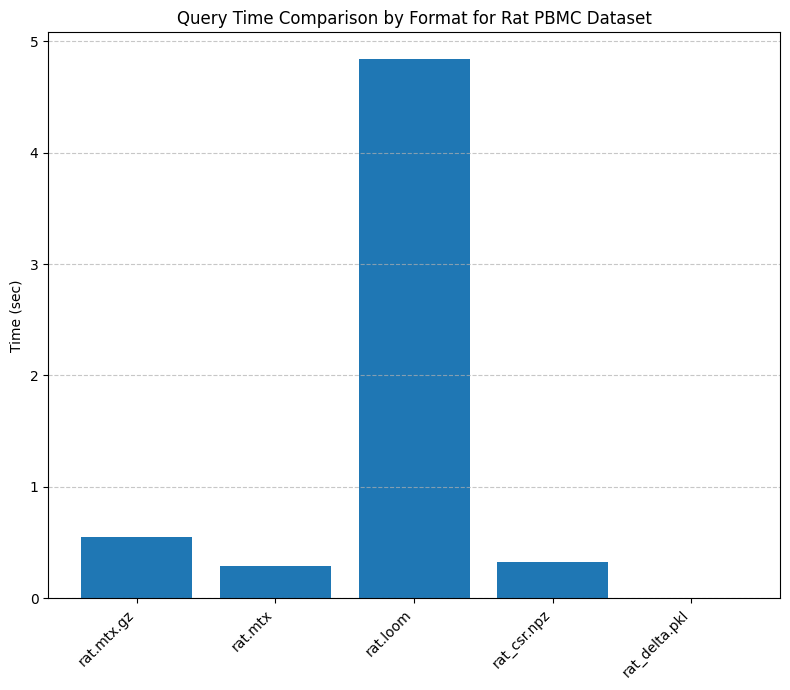

In [23]:
# Ease of use to iterate through all datasets and extensions
files = ["human", "mouse", "rat"]
extensions = [".mtx.gz", ".mtx", ".loom", "_csr.npz", "_delta.pkl"]

for f in files:
    # Draw the 5000th gene from the dataset to query with
    matrix = scipy.io.mmread(f + ".mtx")
    matrix = matrix.tocsr()
    v_g = matrix[5000, :].toarray().flatten()
    
    query_time = []
    start = time.time()
    vector_exists_in_mtx_gz(f + extensions[0], v_g, tol=1e-8)
    end = time.time()
    query_time.append(end - start)

    start = time.time()
    vector_exists_in_mtx(f + extensions[1], v_g, tol=1e-8)
    end = time.time()
    query_time.append(end - start)

    start = time.time()
    vector_exists_in_loom(f + extensions[2], v_g, tol=1e-8)
    end = time.time()
    query_time.append(end - start)

    start = time.time()
    vector_exists_in_csr_npz(f + extensions[3], v_g, tol=1e-8)
    end = time.time()
    query_time.append(end - start)

    start = time.time()
    vector_exists_in_bloom(f + extensions[4], v_g)
    end = time.time()
    query_time.append(end - start)

    fz = [f + ex for ex in extensions]
    # === Step 3: Plot bar chart ===
    plt.figure(figsize=(8, 7))
    plt.bar(fz, query_time)
    plt.ylabel("Time (sec)")
    plt.title("Query Time Comparison by Format for " + f.capitalize() + " PBMC Dataset")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()